**01 -> Importing Standard Libraries**

In [171]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torchsummary import summary
import sys
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

**02 -> Define Custom Libraies**






02.1 -> Common Utils

In [172]:
# Reverse the transformations to get back to a displayable image
def revertNormalizedImageTensor(img_tensor):

    # Create a copy to avoid the in-place modification error
    img_tensor = img_tensor.clone().detach()
    shape_len = len(img_tensor.shape)
    if shape_len == 3:
      channel, height, width = img_tensor.shape
    else:
      channel = 1
      height, width = img_tensor.shape

    if shape_len==3:
    # Transpose channels (C, H, W) to (H, W, C)
      img_tensor = img_tensor.permute(1, 2, 0)

    # Convert to NumPy array and scale to 0-255
    img_numpy = img_tensor.detach().cpu().numpy()
    img_numpy = (img_numpy * 255).astype(np.uint8)

    # Convert to PIL Image
    if channel == 1:
      if shape_len==3:
        img_numpy = np.squeeze(img_numpy, axis=2)

      pil_image = Image.fromarray(img_numpy) #, 'L') # mode option is obsolete
    else:
      pil_image = Image.fromarray(img_numpy)
    return pil_image

In [173]:
def plotImages_Dataset(dataset, class_label, nRows, nCols):
    n_classes  = len(class_label)
    cur_fig, cur_axes = plt.subplots(nRows, nCols)
    labelList = [item[1] for item in dataset]
    indList_UniqueClass = [labelList.index(i) for i in range(n_classes)]
    data = [dataset[idx] for idx in indList_UniqueClass]
    cur_axes = cur_axes.flatten()
    for cur_data, cur_ax in zip(data, cur_axes):
        img = cur_data[0]
        y = cur_data[1]
        # tensor data type has different data orientation
        # tensor:[channel, width, height] -> numpy_format: [width, height, channel]
        img = revertNormalizedImageTensor(img)
        cur_ax.imshow(img, cmap='gray')
        cur_ax.set_title(str(y) + ':' + class_label[y])
        cur_ax.axis('off')
    cur_fig.suptitle('Sample Images for Each Labeled Classes')
    plt.show()

In [174]:
def printInfo_DataLoader(cur_DataLoader, data_category, sep_len=50):
    print("="*sep_len)
    print(f">>>  {data_category}  <<<")
    total_num_samples = cur_DataLoader.dataset.__len__()
    total_num_batches = cur_DataLoader.__len__()
    print(f"Total Number of Samples: {total_num_samples}")
    print(f"Total Number of Batches: {total_num_batches}")
    for X, y in cur_DataLoader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
    print("-"*sep_len)

In [175]:
def determine_maxpool2d_or_conv2d_output_shape(input_shape,C_out, kernel_size, stride, padding, dilation):
    # Note // is for floor division
    C_in, H_in, W_in, = input_shape
    if type(kernel_size) == int:
        kernel_size = [kernel_size]*2
    if type(stride) == int:
        stride = [stride]*2
    if type(padding) == int:
        padding = [padding]*2
    # dilation's default = 1
    if type(dilation) == int:
        dilation = [dilation]*2
    #C_out = C_in
    H_out = (H_in + 2*padding[0] - dilation[0] * (kernel_size[0]-1) - 1) // stride[0] + 1
    W_out = (W_in + 2*padding[1] - dilation[1] * (kernel_size[1]-1) - 1) // stride[1] + 1
    return C_out, H_out, W_out


In [176]:
def determine_convtranpose2d_output_shape(input_shape,C_out, kernel_size, stride, padding, output_padding, dilation):
    # Note // is for floor division
    C_in, H_in, W_in, = input_shape
    if type(kernel_size) == int:
        kernel_size = [kernel_size]*2
    if type(stride) == int:
        stride = [stride]*2
    if type(padding) == int:
        padding = [padding]*2
    # dilation's default = 1
    if type(dilation) == int:
        dilation = [dilation]*2
    H_out = (H_in - 1) * stride[0] - 2 * padding[0] + dilation[0] * (kernel_size[0] - 1) + output_padding + 1
    W_out = (W_in - 1) * stride[1] - 2 * padding[1] + dilation[1] * (kernel_size[1] - 1) + output_padding + 1
    return C_out, H_out, W_out


02.2 -> Define Variational AutoEncoder Model

In [177]:
# Define Customize  LeNet Based Encoder model
class Encoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.latent_dims = latent_dims

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

        self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))#, padding=(1,1))

        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=6,
                               kernel_size=(5,5), stride=(1,1), padding=(0,0))

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,
                               kernel_size=(5,5), stride=(1,1), padding=(0,0))

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120,
                               kernel_size=(5,5), stride=(1,1), padding=(0,0))

        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=self.latent_dims)

        self.fc_to_mu = nn.Linear(in_features=self.latent_dims, out_features=self.latent_dims)
        self.fc_to_logvar = nn.Linear(in_features=self.latent_dims, out_features=self.latent_dims)

        self.input_shapes_dict = dict()
        self.input_shape_flag = True

    def forward(self,x):
        # x is expected to be a batch of images with dimensions as bx1x32x32
        # (batch_size, channel, img_width, img_height)
        if self.input_shape_flag:
            self.input_shapes_dict['input_shape'] = x.shape
            #print(self.input_shapes_dict['input_shape'])

        x = self.leaky_relu(self.conv1(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv1_shape'] = x.shape

        x = self.pool(x)
        if self.input_shape_flag:
            self.input_shapes_dict['pool1_shape'] = x.shape

        x = self.leaky_relu(self.conv2(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv2_shape'] = x.shape

        x = self.pool(x)
        if self.input_shape_flag:
            self.input_shapes_dict['pool2_shape'] = x.shape

        x = self.leaky_relu(self.conv3(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv3_shape'] = x.shape

        x = x.reshape(x.shape[0], -1)
        if self.input_shape_flag:
            self.input_shapes_dict['reshape_shape'] = x.shape

        x = self.leaky_relu(self.fc1(x))
        if self.input_shape_flag:
            self.input_shapes_dict['fc1_shape'] = x.shape

        x = self.tanh(self.fc2(x))
        if self.input_shape_flag:
            self.input_shapes_dict['fc2_shape'] = x.shape
            self.input_shape_flag = False

        mu = self.fc_to_mu(x)
        logvar = self.fc_to_logvar(x)
        return mu, logvar

In [178]:
# Define Customize Decoder model
class Decoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super(Decoder, self).__init__()
        self.latent_dims = latent_dims
        self.img_channel = in_channels

        self.leaky_relu = nn.LeakyReLU ()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

        self.fc1 = nn.Linear(in_features=self.latent_dims, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=120)

        self.convtranpose2d_1 = nn.ConvTranspose2d(in_channels=120, out_channels=16,
                                                   kernel_size=(5,5), stride=(1,1), padding=(0,0),
                                                   output_padding=(0,0))

        self.convtranpose2d_2 = nn.ConvTranspose2d(in_channels=16, out_channels=16,
                                                   kernel_size=(6,6), stride=(1,1), padding=(0,0),
                                                   output_padding=(0,0))

        self.convtranpose2d_3 = nn.ConvTranspose2d(in_channels=16, out_channels=6,
                                                   kernel_size=(7,7), stride=(1,1), padding=(1,1),
                                                   output_padding=(0,0))

        self.convtranpose2d_4 =nn. ConvTranspose2d(in_channels=6, out_channels=6,
                                                   kernel_size=(5,5), stride=(2,2), padding=(2,2),
                                                   output_padding=(1,1))

        self.convtranpose2d_5 = nn.ConvTranspose2d(in_channels=6, out_channels=self.img_channel,
                                                   kernel_size=(7,7), stride=(1,1), padding=(1,1),
                                                   output_padding=(0,0))

        self.input_shapes_dict = dict()
        self.input_shape_flag = True

    def forward(self,x):
        # x is expected to be a batch of images with dimensions as bx1x28x28
        # (batch_size, channel, img_width, img_height)
        if self.input_shape_flag:
            self.input_shapes_dict['input_shape'] = x.shape

        x = self.leaky_relu(self.fc1(x))
        if self.input_shape_flag:
            self.input_shapes_dict['fc1_shape'] = x.shape

        x = self.leaky_relu(self.fc2(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        if self.input_shape_flag:
            self.input_shapes_dict['fc2_shape'] = x.shape

        x = self.leaky_relu(self.convtranpose2d_1(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv2T_1_shape'] = x.shape

        x = self.leaky_relu(self.convtranpose2d_2(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv2T_2_shape'] = x.shape

        x = self.leaky_relu(self.convtranpose2d_3(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv2T_3_shape'] = x.shape

        x = self.leaky_relu(self.convtranpose2d_4(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv2T_4_shape'] = x.shape

        x = self.sigmoid(self.convtranpose2d_5(x))
        if self.input_shape_flag:
            self.input_shapes_dict['conv2T_5_shape'] = x.shape
            self.input_shape_flag = False
        return x

In [179]:
# Variational AutoEncoder
class Custom_VAE(nn.Module):
    def __init__(self, local_device, in_channels = 3, latent_dims = 256):
        super(Custom_VAE, self).__init__()
        self.latent_dims = latent_dims
        self.in_channels = in_channels
        self.device = local_device
        self.encoder = Encoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)
        self.mu = []
        self.logvar = []

    def forward(self,x):
        # x is an image
        mu, logvar = self.encoder(x)
        # std = exp( 0.5 * log(std^2)) -> exp(0.5*2 log(std))
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        self.mu = mu
        self.logvar = logvar
        # New z latent vector
        z = mu + eps * std
        img_reconstructed = self.decoder(z)
        return img_reconstructed, mu, logvar


In [180]:
def loss_function(img, img_reconstructed, mean, log_var):
  '''
  Note: both img_reconstructed and img needs to be between 0 to 1
  for binary_cross_entropy to work
  '''
  reproduction_loss = nn.functional.binary_cross_entropy(img_reconstructed, img, reduction='sum')
  KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

  return reproduction_loss + KLD

02.3 -> Model Trainig Utils

In [181]:
# Training (Note: Model need not to be return, all weights are updated within)
def train_model(train_dataloader, model, loss_fn, optimizer, device):
    total_num_of_batches = len(train_dataloader)
    total_num_of_samples = len(train_dataloader.dataset)

    zero_pad_width    = int(np.ceil(np.log10(total_num_of_batches)))
    cur_total_samples = 0
    batch_loss_list   = list()

    # Enable weight updates
    model.train()

    for batch, (X, y) in enumerate(train_dataloader):
        '''X size [Batch, Channel, Width, Height]: (BatchSize, 1, 32, 32)
           y size:(BatchSize, 1) -> second dimension is an integer value between 0 to 9
           y is not used and we are aiming to reconstruct X
        '''
        X = X.to(device)
        cur_total_samples = cur_total_samples + X.shape[0]

        # Model prediction -> logits -> [Batch, channel, width, height]
        X_reconstructed, mu, logVar = model(X)
        X_reconstructed = X_reconstructed.to(device)

        # Compute loss between images and reconstructed images
        batch_loss = loss_fn(X, X_reconstructed, mu, logVar)

        # Note: Forward-pass will automatically save gradients between nodes
        # Reset all gradient before loss computation
        optimizer.zero_grad()

        # Backpropagation with chain rule
        batch_loss.backward()

        # Update weights with current optimizer setting
        optimizer.step()

        batch_loss_list.append(batch_loss.item())

        if batch % 100 == 0 or batch == total_num_of_batches-1:
            batch_loss_value = batch_loss.item()
            # >7f -> right align with 7 characters with fixed floating points
            print(f"batch#: {str(batch).rjust(zero_pad_width,'0')} "
                  f"batch_loss: {batch_loss_value:>7f}  "
                  f"[{cur_total_samples:>5d}/{total_num_of_samples:>5d}]")

    epoch_loss = np.mean(batch_loss_list)
    return epoch_loss

In [182]:
# Evaluation Stage
def evaluate(valid_dataloader, model, loss_fn, device):
    total_num_of_batches = len(valid_dataloader)
    total_num_of_samples = len(valid_dataloader.dataset)

    batch_loss_valid = 0
    batch_loss_list = []

    # Model Eval will #1).deactivate updates for BatchNorm
    # and 2). disable Dropout usage
    model.eval()

    # While working with evaluation, deactivate autograd engine to
    # 1). reduce memory usage, 2). stop weight updates
    # and 3). speeds up computation
    with (torch.no_grad()):
        for X, y in valid_dataloader:
            X = X.to(device)

            # Model prediction -> [batch_size, channel, width, height]
            X_reconstructed, mu, logVar = model(X)
            X_reconstructed = X_reconstructed.to(device)

            # Sum up all losses from each batch
            batch_loss_valid = loss_fn(X, X_reconstructed, mu, logVar)
            batch_loss_list.append(batch_loss_valid.item())

    epoch_loss = np.mean(batch_loss_list)
    return epoch_loss

In [183]:
def train_model_under_n_epochs(train_dataloader, valid_dataloader,
                               epochs, model, loss_fn, optimizer, device):
    sep_len = 50
    best_valid_loss = np.inf
    model_train_loss = np.inf

    epoch_metrics = defaultdict(list)
    print(f"=" * sep_len)
    print(f" >>> Model Training with {epochs} epochs <<<")
    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        train_loss = train_model(train_dataloader, model, loss_fn, optimizer, device)
        valid_loss = evaluate(valid_dataloader, model, loss_fn, device)

        epoch_metrics['train_loss_list'].append(train_loss)
        epoch_metrics['valid_loss_list'].append(valid_loss)

        # Save only the best valid loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model_train_loss = train_loss
            torch.save(model.state_dict(), "optimal_Custom_VAE_state_dict.pt")

        print(f"epoch {epoch}  -> training and validation results\n"
              f"train_loss: {train_loss:.5f}\n"
              f"valid_loss: {valid_loss:.5f}")
        print(f"~" * sep_len)

    print(f"Final Best valid loss: {best_valid_loss:>.5f}  "
          f"Saved Model's Train Loss: {model_train_loss:>.5f}")
    print(f"-" * sep_len)
    return epoch_metrics, best_valid_loss

**02.4 Model Prediction**

In [184]:
# Define prediction function
def generate_images(mu, var, model, device, plotSel=True):
  epsilon = torch.randn_like(var).to(device)
  z = mu + var*epsilon
  z = z.to(device)
  img_reconstructed = model.decoder(z)
  img = img_reconstructed.squeeze(0)
  img=revertNormalizedImageTensor(img)
  if plotSel==True:
    plt.imshow(img)
    plt.axis('off')
    plt.show()
  return img


**03 -> Check available accerlerator and package versions**

In [185]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"* Current Available Accelerator Device: {device}")
print(f"* torch version: {torch.__version__}")
print(f"* torchvision version: {torchvision.__version__}")
print(f"* python version: {sys.version}")

* Current Available Accelerator Device: cuda
* torch version: 2.9.0+cu126
* torchvision version: 0.24.0+cu126
* python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


**04 -> Preparing your training data and validation data**

In [186]:
my_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])

In [187]:
training_data = datasets.MNIST(root="online_data/MNIST",
                                      train=True,
                                      download=True,
                                      transform=my_transforms
                                      )

In [188]:
valid_data = datasets.MNIST(root="online_data/MNIST",
                                   train=False,
                                   download=True,
                                   transform=my_transforms
                                   )

**05 -> Information about the dataset**

In [189]:
classLabel2Ind = training_data.class_to_idx
classLabel = dict()
for iKey in classLabel2Ind:
  classLabel[classLabel2Ind[iKey]] = iKey

print(f"* Image's Original shape [width, height]: {valid_data.data[0].shape}")
print(f"* Image data-type: {type(valid_data.data[0])}")
print(f"* Training data size: {training_data.data.shape}")
print(f"* Validation data size: {valid_data.data.shape}")

* Image's Original shape [width, height]: torch.Size([28, 28])
* Image data-type: <class 'torch.Tensor'>
* Training data size: torch.Size([60000, 28, 28])
* Validation data size: torch.Size([10000, 28, 28])


**06 -> View Sample Images**

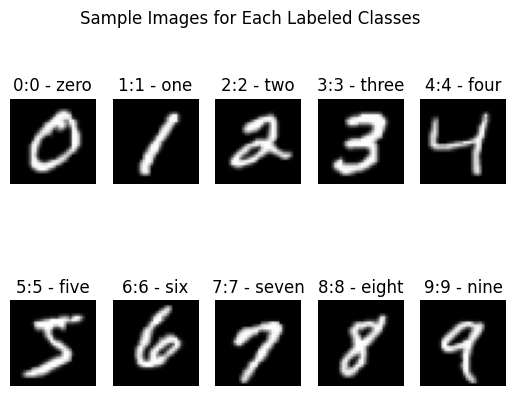

In [190]:
plotImages_Dataset(training_data, classLabel, nRows=2, nCols=5)

**07 -> Hyperparameters**

In [191]:
# Note: Use image as input in LSTM
# imgSize(3, 32, 32) -> (Channel, Row/Height, Col/Width) -> need squeeze image as (32,32)
# View an image as a sample with 1 time_step
in_channels = 1
img_width = 32
img_height = 32
latent_size = 128
num_classes = 10
learning_rate = 1e-3
batch_size = 64
epochs = 50

**08 -> Prepare dataloader and print some basic info on each dataset**

In [192]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

printInfo_DataLoader(train_dataloader, 'Training DataSet')
printInfo_DataLoader(valid_dataloader, 'Validating DataSet')

>>>  Training DataSet  <<<
Total Number of Samples: 60000
Total Number of Batches: 938
Shape of X [N, C, H, W]: torch.Size([64, 1, 32, 32])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------
>>>  Validating DataSet  <<<
Total Number of Samples: 10000
Total Number of Batches: 157
Shape of X [N, C, H, W]: torch.Size([64, 1, 32, 32])
Shape of y: torch.Size([64]) torch.int64
--------------------------------------------------


**09 -> Setup Model and View Basic Layer Info**

In [193]:
model_encoder = Encoder(in_channels, latent_size).to(device)
print(f">>>> Encoder Architecture:")
summary(model_encoder, (in_channels, img_height, img_width), batch_size)
print(f"\n")

model_decoder = Decoder(in_channels, latent_size).to(device)
print(f">>>> Decoder Architecture:")
summary(model_decoder, (latent_size,), batch_size)
print(f"\n")

model= Custom_VAE(device, in_channels, latent_size).to(device)
print(f">>>> VAE Architecture:")
summary(model, (in_channels, img_height, img_width), batch_size)


>>>> Encoder Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 6, 28, 28]             156
         LeakyReLU-2            [64, 6, 28, 28]               0
         AvgPool2d-3            [64, 6, 14, 14]               0
            Conv2d-4           [64, 16, 10, 10]           2,416
         LeakyReLU-5           [64, 16, 10, 10]               0
         AvgPool2d-6             [64, 16, 5, 5]               0
            Conv2d-7            [64, 120, 1, 1]          48,120
         LeakyReLU-8            [64, 120, 1, 1]               0
            Linear-9                   [64, 84]          10,164
        LeakyReLU-10                   [64, 84]               0
           Linear-11                  [64, 128]          10,880
             Tanh-12                  [64, 128]               0
           Linear-13                  [64, 128]          16,512
           L

**10 -> Loss function and optimizer setup**

In [194]:
loss_fn = loss_function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**11 -> Train model under n epochs**

In [195]:
epoch_metrics, best_valid_loss = train_model_under_n_epochs(train_dataloader,
                                                           valid_dataloader,
                                                           epochs,
                                                           model,
                                                           loss_fn,
                                                           optimizer,
                                                           device)

 >>> Model Training with 50 epochs <<<
epoch: 0
batch#: 000 batch_loss: 42379.121094  [   64/60000]
batch#: 100 batch_loss: 18129.085938  [ 6464/60000]
batch#: 200 batch_loss: 16369.455078  [12864/60000]
batch#: 300 batch_loss: 18366.386719  [19264/60000]
batch#: 400 batch_loss: 16939.548828  [25664/60000]
batch#: 500 batch_loss: 16729.798828  [32064/60000]
batch#: 600 batch_loss: 15672.370117  [38464/60000]
batch#: 700 batch_loss: 15833.701172  [44864/60000]
batch#: 800 batch_loss: 17540.937500  [51264/60000]
batch#: 900 batch_loss: 15667.314453  [57664/60000]
batch#: 937 batch_loss: 8194.261719  [60000/60000]
epoch 0  -> training and validation results
train_loss: 17572.17338
valid_loss: 16341.11798
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch: 1
batch#: 000 batch_loss: 15847.414062  [   64/60000]
batch#: 100 batch_loss: 15907.238281  [ 6464/60000]
batch#: 200 batch_loss: 14475.955078  [12864/60000]
batch#: 300 batch_loss: 16297.229492  [19264/60000]
batch#: 400 batch_los

Model Prediction

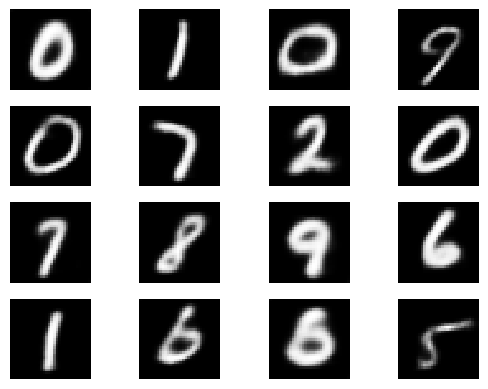

In [207]:
sel_randParams = 1
fig,axs = plt.subplots(4,4)
axs_n =[ax for ax in axs.flatten()]
plotSel=False
for i in range(16):
  if sel_randParams==0:
    mu = model.mu[i]
    var = model.logvar[i]
  else:
    mu = torch.randn(latent_size).to(device)
    var = torch.randn(latent_size).to(device)
  cur_img = generate_images(mu, var, model, device,plotSel)
  axs_n[i].imshow(cur_img, interpolation='none', cmap='gray')
  axs_n[i].axis('off')
plt.show()

**References:**


1.   https://www.youtube.com/watch?v=VELQT1-hILo
2.   https://www.geeksforgeeks.org/computer-vision/what-is-lenet/
3.   https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f
4.   https://www.datacamp.com/tutorial/variational-autoencoders
5.   https://mbernste.github.io/posts/vae/
6.   https://stackoverflow.com/questions/60327520/keras-variational-autoencoder-loss-function



